In [12]:
import numpy as np
import matplotlib.pyplot as plt

class MLP: # 다중층 퍼셉트론
    def __init__(self, input_size, hidden_size, output_size, lr=0.05, epochs=50000):
        self.lr = lr
        self.epochs = epochs
        self.errors = []

        # 가중치 초기화: 작은 난수
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))

        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_output = np.zeros((1, output_size))

    def sigmoid(self, x):               # sigmoid 함수 (비선형 이진 분류 활성화 함수) : 값이 0.5 이상일 경우, 1로 판단.
        x = np.clip(x, -500, 500)       # overflow 방지
        return 1 / (1 + np.exp(-x))     # hidden layer를 여러개 쌓아도 활성화 함수가 선형이면 비선형 연산은 불가능 (XOR 등)

    def sigmoid_derivative(self, x):    # sigmoid 기울기 계산 (미분 값)
        return x * (1 - x)

    def predict(self, x):
        # 1. 입력층 -> 은닉층 계산
        x = x.reshape(1, -1)            # 입력 x를 (1, input_size) 형태의 2차원 배열로 변환 (행렬 연산 준비)
        hidden_input = np.dot(x, self.weights_input_hidden) + self.bias_hidden  # 입력 x와 input, hidden 가중치를 행렬 곱 한 후, hidden 편향을 더함.
        hidden_output = self.sigmoid(hidden_input)

        # 2. 은닉충 -> 출력층 계산
        output_input = np.dot(hidden_output, self.weights_hidden_output) + self.bias_output
        output = self.sigmoid(output_input)
        return output[0, 0]  # 스칼라 반환

    def train(self, X, y):
        y = y.reshape(-1, 1)  # (4, 1) 형태로

        for epoch in range(self.epochs):
            total_error = 0
            for xi, target in zip(X, y):
                xi = xi.reshape(1, -1)   # (1, 2)
                target = target.reshape(1, -1)  # (1, 1)

                # 순방향 전파 : 각 층의 입력 및 출력 값이 저장.
                # hidden layer
                hidden_input = np.dot(xi, self.weights_input_hidden) + self.bias_hidden # input 가중 합 연산
                hidden_output = self.sigmoid(hidden_input)  # 활성화 함수인 sigmoid 함수를 통과하여 hidden layer의 출력 생성.

                output_input = np.dot(hidden_output, self.weights_hidden_output) + self.bias_output # hidden 가중 합 연산
                output = self.sigmoid(output_input)

                # 오류 계산 : MSE를 사용하여 예측과 정답 사이의 오차를 계산.
                error = target - output
                total_error += np.sum(error ** 2)  # Loss funcion으로 Mean Square Error 사용. 학습이 진행될수록 이 값을 줄이는 것이 목표.

                # 역방향 전파
                delta_output = error * self.sigmoid_derivative(output) # 출력층의 오류 기울기 계산
                delta_hidden = np.dot(delta_output, self.weights_hidden_output.T) * self.sigmoid_derivative(hidden_output) # 은닉층의 오류 기울기 계산

                # 가중치 & 편향 업데이트 : 개선된 기울기를 사용하여 업데이트
                self.weights_hidden_output += self.lr * np.dot(hidden_output.T, delta_output)
                self.bias_output += self.lr * delta_output

                self.weights_input_hidden += self.lr * np.dot(xi.T, delta_hidden)
                self.bias_hidden += self.lr * delta_hidden

            self.errors.append(total_error)
            if (epoch + 1) % 1000 == 0:
                print(f"Epoch {epoch+1}/{self.epochs} - Total Error: {total_error:.6f}")

 # XOR 데이터
x_xor = np.array([[0,0], [0,1], [1,0], [1,1]])
y_xor = np.array([0,1,1,0])

# MLP 모델 생성 및 학습
mlp = MLP(input_size=2, hidden_size=6, output_size=1, lr=0.1, epochs=10000)
mlp.train(x_xor, y_xor)

# 예측 확인
print("\nXOR Gate Test (with Hidden Layer):")
for x in x_xor:
    out = mlp.predict(x)
    print(f"Input: {x}, Predicted: {out:.4f}, Binary: {int(out > 0.5)}")

Epoch 1000/10000 - Total Error: 0.805646
Epoch 2000/10000 - Total Error: 0.228512
Epoch 3000/10000 - Total Error: 0.069006
Epoch 4000/10000 - Total Error: 0.035098
Epoch 5000/10000 - Total Error: 0.022493
Epoch 6000/10000 - Total Error: 0.016220
Epoch 7000/10000 - Total Error: 0.012545
Epoch 8000/10000 - Total Error: 0.010158
Epoch 9000/10000 - Total Error: 0.008496
Epoch 10000/10000 - Total Error: 0.007277

XOR Gate Test (with Hidden Layer):
Input: [0 0], Predicted: 0.0292, Binary: 0
Input: [0 1], Predicted: 0.9580, Binary: 1
Input: [1 0], Predicted: 0.9542, Binary: 1
Input: [1 1], Predicted: 0.0505, Binary: 0


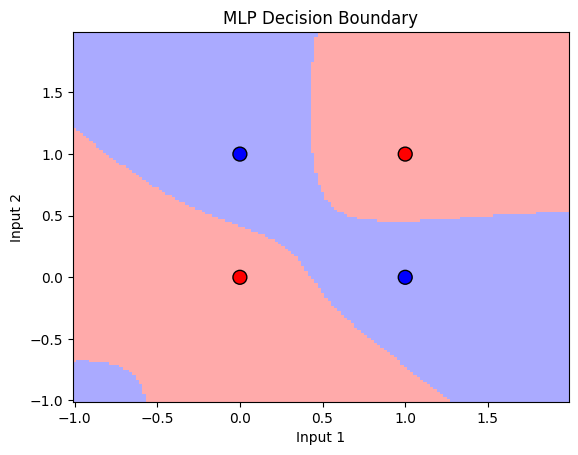

In [11]:
# ---경계 결정 시각화---
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, model):
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    h = .02 # mesh grid 간격
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    input_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.array([int(model.predict(xi) > 0.5) for xi in input_grid])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    #실제 데이터 포인트 표시
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=100, marker='o')
    plt.xlabel('Input 1')
    plt.ylabel('Input 2')
    plt.title('MLP Decision Boundary')
    plt.show()

# XOR 게이트 결정 경계 시각화
plot_decision_boundary(x_xor, y_xor, mlp)

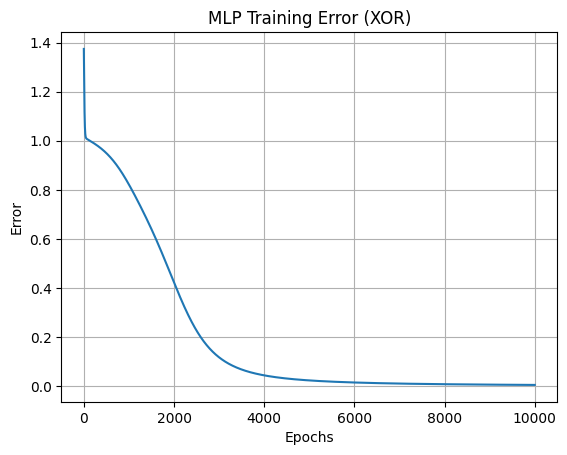

In [7]:
# ---오류 시각화---
'''plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ppn_xor.errors) + 1), ppn_xor.errors, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of Updates')
plt.title('Perceptron Learning Error Over Epochs (XOR Gate)')
plt.grid(True)
plt.show()'''

# 학습 오류 시각화
plt.plot(range(len(mlp.errors)), mlp.errors)
plt.title("MLP Training Error (XOR)")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.grid(True)
plt.show()

